# Graph Analysis
## Data Download
In order to analyse the data we first need to read in the scala output. Unfortuantely, the output of the scala program has created a folder of various csv's rather than producing one file. As such we need to iterate through each one and append the data into one DataFrame. The csv naming scheme was 'part-00[200-399,600-799]' followed by the same string of characters. However, for some reason the scheme does not include 605,685 or 708. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
app1 = pd.read_csv("../data/sent1.csv/part-00200-7d6177c2-d913-4829-b6e3-3a1722f32bcd-c000.csv",names=["id","neg_sentiment"])
app1 = pd.concat([app1, pd.read_csv("../data/sent1.csv/part-00600-7d6177c2-d913-4829-b6e3-3a1722f32bcd-c000.csv",names=["id","neg_sentiment"])],ignore_index=True)
for i in range(1,200):
    n = 200+i
    app1 = pd.concat([app1,pd.read_csv("../data/sent1.csv/part-00"+str(n)+"-7d6177c2-d913-4829-b6e3-3a1722f32bcd-c000.csv",names=["id","neg_sentiment"])],ignore_index=True)
    if (i != 5) & (i != 85) & (i != 108):
        m = 600+i
        app1 = pd.concat([app1,pd.read_csv("../data/sent1.csv/part-00"+str(m)+"-7d6177c2-d913-4829-b6e3-3a1722f32bcd-c000.csv",names=["id","neg_sentiment"])],ignore_index=True)

In [3]:
app2 = pd.read_csv("../data/sent2.csv/part-00200-639f09f3-46ed-41c8-91c5-b12e3652562e-c000.csv",names=["id","neg_sentiment"])
app2 = pd.concat([app2, pd.read_csv("../data/sent2.csv/part-00600-639f09f3-46ed-41c8-91c5-b12e3652562e-c000.csv",names=["id","neg_sentiment"])],ignore_index=True)
for i in range(1,200):
    n = 200+i
    app2 = pd.concat([app2,pd.read_csv("../data/sent2.csv/part-00"+str(n)+"-639f09f3-46ed-41c8-91c5-b12e3652562e-c000.csv",names=["id","neg_sentiment"])],ignore_index=True)
    if (i != 5) & (i != 85) & (i != 108):    
        m = 600+i
        app2 = pd.concat([app2,pd.read_csv("../data/sent2.csv/part-00"+str(m)+"-639f09f3-46ed-41c8-91c5-b12e3652562e-c000.csv",names=["id","neg_sentiment"])],ignore_index=True)

## Connected Components

Unfortunately, I was unable to find a way to effectively input the connected component csv's due to the naming of the files. However, from the input of the program I called a describe function on the output of the connected components function, which displayed that all vales were 0. This means that all nodes were in the same connected component as each other. 

## Basic Analysis

In order to simulate negative sentiment spreading through a network, we first assigned the a negative sentiment of 1 to everyone who is fired during the period of data collection and 0 to everyone else. Then for each vertex, sum the weights for each in-edge (calculated differently for each approach), and adding this sum to the negative sentiment of the vertex. This new negative sentiment is then used as the prior for the next iteration using the same method. Therefore, we have negative sentiment spreading throughout the network with a higher value indicating a higher likelihood of being an insider threat. 

You will notice that there is no method for obstructing 'sentiment reflection' this is because if A is angry, this is highly likely to make B angrier than B already was and if B is angrier then this is more likely to make A angrier. Therefore, we believe that this is a realistic side-effect and did not obstruct it.


### Approach 1
For approach 1, consider an edge a->b. The weight of this edge is = a('neg_sentiment') / inDegree(b). The reasoning behind this approach is that we need to convey the negative sentiment of the source node, however we reason that if the destination node receives lots of emails, then they are less likely to be affected by the sentiment of one person. 

Originally we wanted to also divide by the outDegree(a) but reasoned that just because a sends out lots of emails, doesn't mean their effect on the recipient is any different. 

In [4]:
app1["neg_sentiment"].describe()

count    4432.000000
mean        0.003776
std         0.042134
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.108481
Name: neg_sentiment, dtype: float64

In [5]:
count1 = (app1["neg_sentiment"] == 0).sum()
count1

3477

### Approach 2
For approach 2 we used a page rank algorithm to calculate the importance of each edge to the populaity of the graph. We then multiplied this importance by the negative sentiment of the source node, this is the weight of edge. We chose this as this provides a better theroetical weighting of the importance of edges so by multiplying this by the negative sentiment, we hoped this would provide a better method for the spread of negative sentiment throughout the graph. 

In [6]:
app2["neg_sentiment"].describe()

count     4432.000000
mean        45.968997
std        673.541401
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      24594.844048
Name: neg_sentiment, dtype: float64

In [7]:
count2 = (app2["neg_sentiment"] == 0).sum()
count2

3477

We can see that both show that the vast majority of vertices have 0 negative_sentiment, with 3477 out of 4432. It makes sense that the number of 0 neg_sentiment vertices are the same on each approach as the negative sentiment approaches are both increasing functions with the property that (the score of approach 1 > 0) iff (the score of approach 2 > 0). 

However, the fact that there are so many 0 vertices with 0 negative sentiment shows that rather than just 2 iterations of dissemination, that we should have had more iterations. The reasoning behind this is that, by having so many 0's means the data is harder to analyse for this project. Also I do not believe that it is realistic that that many people would not be affected at all by the firings. 

Now, this number of iterations could be realistic at negative sentiment dissemination via email because email is such a small part of a work communication infrastructure (with instant messaging, meetings and general office chatter). However, I think that by increasing the number of iterations this could help close the gap between the holistic negative sentiment dissemination, even if it decreases the realism of negative sentiment dissemination via email.

There is a very big difference between the summary statistics of both approaches. Approach 1 is much more what I was expecting with max values around 1. On the otherhand, approach 2 produced much higher scores than I was expecting. I am confused at to why the values of approach 2 are so high, given that the edge weights produced by the page rank algorithm were between 1 and 0, so summing should not have produced such high values. Never the less, we shall normalise both approaches and compare their normalised forms.  

### Detailed Analysis
Now that we have seen the basics of the data, we can start to compare the results of the two approaches in more detail. While we will not be able to explicitly say which is the better approach but we will hopefully be able to make some reasonable conclusions. We will start by normalising the results by dividing by the maximum negative sentiment to get values between 0 and 1.

In [8]:
app1_1 = app1
app2_1 = app2
app1_1['neg_sentiment'] = app1['neg_sentiment'] / app1['neg_sentiment'].max()
app2_1['neg_sentiment'] = app2['neg_sentiment'] / app2['neg_sentiment'].max()

(array([4.411e+03, 1.000e+01, 2.000e+00, 2.000e+00, 4.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

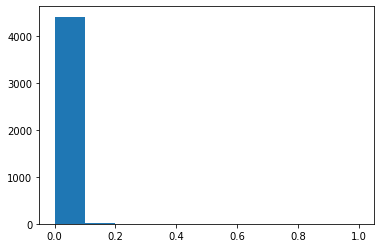

In [9]:
plt.hist(app2['neg_sentiment'])

Having seen this histogram, data analysis will be difficult while keeping all the 0 values. As the vertices with a score of 0 will be the same in both approaches, we can safely remove them without affecting the analysis.

In [10]:
app1_1 = app1.loc[(app1['neg_sentiment']!=0)]
app2_1 = app2.loc[(app2['neg_sentiment']!=0)]

(array([934.,  10.,   2.,   2.,   4.,   1.,   0.,   1.,   0.,   1.]),
 array([5.22131837e-10, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

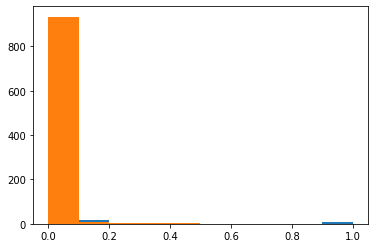

In [11]:
plt.hist(app1_1['neg_sentiment'])
plt.hist(app2_1['neg_sentiment'])

Here we have that the orange bars are approach 2 and blue are approach 1. We can see that the same number of people lie between 0 and 0.1 for both approaches. The main difference lies in where the rest of the data is distributed. In approach 1, there is a small clustering at 0.1 - 0.2 and 0.9 - 1. Where has approach 2 only has values < 0.5. This is unexpected as you would expect a resonable number of values to apprear in 0.9 - 1 range as these will be the values of those who have been fired or are close to those that have. 

We will therefore try mean normalisation to see if we can extract this data.

(array([4408.,   17.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           7.]),
 array([-0.08962751,  2.54120789,  5.17204329,  7.80287869, 10.43371409,
        13.06454948, 15.69538488, 18.32622028, 20.95705568, 23.58789108,
        26.21872648]),
 <BarContainer object of 10 artists>)

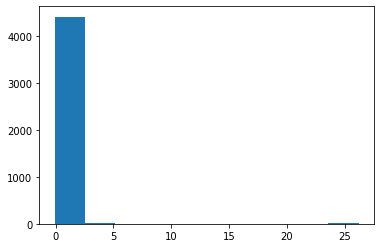

In [12]:
app1_2 = app1
app2_2 = app2
app1_2['neg_sentiment'] = (app1['neg_sentiment'] - app1['neg_sentiment'].mean())/ app1['neg_sentiment'].std() 
app2_2['neg_sentiment'] = (app2['neg_sentiment'] - app2['neg_sentiment'].mean())/ app2['neg_sentiment'].std() 
plt.hist(app1_2['neg_sentiment'])

(array([4.411e+03, 1.000e+01, 2.000e+00, 2.000e+00, 4.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([-0.0682497 ,  3.58332154,  7.23489278, 10.88646401, 14.53803525,
        18.18960648, 21.84117772, 25.49274896, 29.14432019, 32.79589143,
        36.44746267]),
 <BarContainer object of 10 artists>)

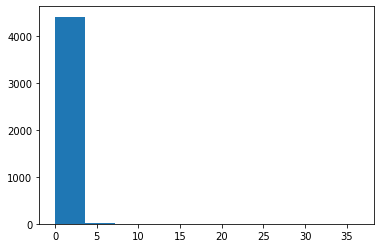

In [13]:
plt.hist(app2_2['neg_sentiment'])

After comparing the newly normalised data, we can see that this has not really help with extracting the pattern out of approach 2. Therefore, we conclude that the page rank weighting has overpowered the weighting of the negative sentiment as we would at least expect 7 values that high with fairly similar values (those who were fired). However, from both normalisation methods, this does not exist. Approach 1 however, shows the peak as we would expect. 

We would have expected more values lying between 0.1 and 0.9 (returning to the original normalisation of approach 1), especially for those who were close to those who were fired. Approach 2 has more values in this region, however these are predominantly those who were fired being watered down. 

Therefore, we have to conclude of the two approaches, approach 1 was most successful as it did not overpower the inital input. However, it is clear that the negative sentiment needs to have a higher weighting when spreading over an edge. This could be done by including a constant so that each edge is 'c' times more conductive than before. If we could work out the reason behind the unexpectedly high values returned by approach 2, this could provide a better analysis.

Due to the analysis of the approaches, I do not feel confident that analysing the data further, to calculate other employees that are high risk, would provide useful results. 